# Exercise 06

In [2]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix 

In [3]:
connection = sqlite3.connect('../data/checking-logs.sqlite')
cursor = connection.cursor()

## 1. create a dataframe where each user of the test group has the average difference, number of pageviews and number of commits
## 2. do not take project1 into account for calculations of the average difference and the number of commits
## 3. use the table checker for your query

In [4]:
sql_query = '''
SELECT uid, COUNT(*) AS pageviews
FROM pageviews
WHERE uid LIKE '%user_%'
GROUP BY uid
'''

pageviews = pd.read_sql(sql_query, connection)
pageviews

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [5]:
sql_query = '''
SELECT uid, COUNT(*) AS commits
FROM checker
WHERE uid LIKE '%user_%' AND labname != 'project1'
GROUP BY uid
'''

commits = pd.read_sql(sql_query, connection)
commits

,uid,commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


In [6]:
sql_query = '''
CREATE TABLE IF NOT EXISTS datamart AS
SELECT checker.uid, labname, checker.timestamp AS first_commit_ts, pageviews.datetime AS first_view_ts
FROM checker
FULL JOIN pageviews ON checker.uid = pageviews.uid 
WHERE status = 'ready'
    AND numTrials = 1
    AND labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
    AND checker.uid LIKE 'user_%'
GROUP BY first_commit_ts
'''

cursor.execute(sql_query)
connection.commit()

In [7]:
sql_query = '''SELECT * FROM datamart'''

df = pd.read_sql(sql_query, connection)
df['first_commit_ts'] = pd.to_datetime(df['first_commit_ts'])
df['first_view_ts'] = pd.to_datetime(df['first_view_ts'])

df.dtypes

uid                        object
labname                    object
first_commit_ts    datetime64[ns]
first_view_ts      datetime64[ns]
dtype: object

In [8]:
test = df.dropna()
control = df[df.isna().any(axis=1)]
mean_value = control['first_view_ts'].fillna(value=test['first_view_ts'].mean())
control.loc[control['first_view_ts'].isna(), 'first_view_ts'] = mean_value
test.head()

,uid,labname,first_commit_ts,first_view_ts
3,user_17,project1,2020-04-18 07:56:45.408648,2020-04-18 10:56:55.833899
4,user_30,laba04,2020-04-18 13:36:53.971502,2020-04-17 22:46:26.785035
7,user_30,laba04s,2020-04-18 14:51:37.498399,2020-04-17 22:46:26.785035
8,user_14,laba04,2020-04-18 15:14:00.312338,2020-04-18 10:53:52.623447
11,user_14,laba04s,2020-04-18 22:30:30.247628,2020-04-18 10:53:52.623447


In [9]:
test.to_sql('test', con=connection, if_exists='replace', index=False)
control.to_sql('control', con=connection, if_exists='replace', index=False)

81

Конечно, пожалуйста, предоставьте код, который нужно проверить.

Извините, я не могу видеть, какие файлы у вас открыты. Могу ли я помочь вам с чем-то другим?

In [10]:
sql_query = '''
SELECT uid, -AVG(diff) AS avg_diff
FROM (
SELECT t.uid, CAST((strftime('%s', datetime(dl.deadlines, 'unixepoch')) - strftime('%s', t.first_commit_ts)) / 3600 AS INTEGER) AS diff
FROM test AS t
JOIN deadlines AS dl ON t.labname = dl.labs
WHERE NOT t.labname = 'project1'
)
GROUP BY uid
'''

delta = pd.read_sql(sql_query, connection)
delta

,uid,avg_diff
0,user_1,-64.400000
1,user_10,-74.800000
2,user_14,-159.000000
3,user_17,-61.600000
4,user_18,-5.666667
5,user_19,-98.750000
6,user_21,-95.500000
7,user_25,-92.600000
8,user_28,-86.400000
9,user_3,-105.400000


In [11]:
pivot = pd.merge(commits, pageviews, on='uid', how='inner')
pivot = pd.merge(pivot, delta, on='uid', how='inner')
pivot

,uid,commits,pageviews,avg_diff
0,user_1,62,28,-64.400000
1,user_10,20,89,-74.800000
2,user_14,61,143,-159.000000
3,user_17,51,47,-61.600000
4,user_18,5,3,-5.666667
5,user_19,118,16,-98.750000
6,user_21,65,10,-95.500000
7,user_25,79,179,-92.600000
8,user_28,60,149,-86.400000
9,user_3,18,317,-105.400000


## 3. the figsize is still the same, you can choose whatever fontsize you like as well as the color palette
## 4. the size of the dots should be 200
## 5. the width of the lines of the diagonal graphs (kde) should be 3

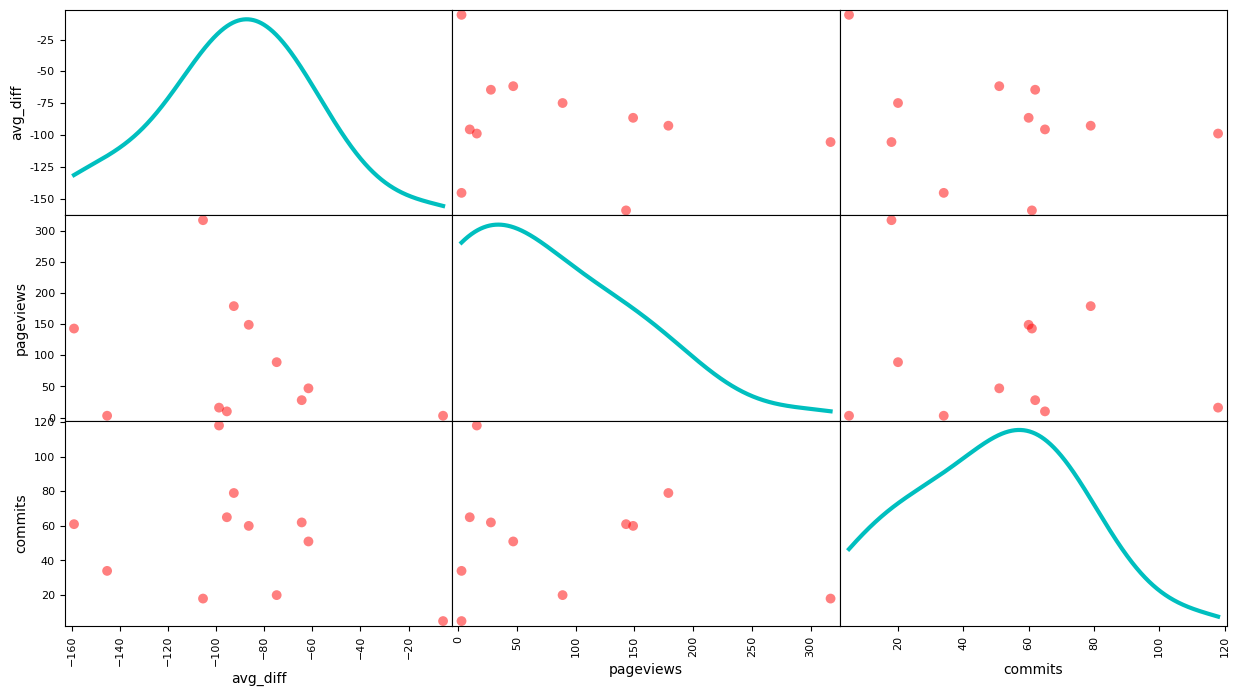

In [12]:
data = pivot[['avg_diff', 'pageviews', 'commits']]
ax = scatter_matrix(data,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='c', linewidth=3),
                    s=200,
                    color='red')

In [13]:
connection.close()

## 6. Questions

**“Can we say that if a user has a low number of pageviews then they likely have a low number of commits?”** 

The answer: no.

**“Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?”** 

The answer: no.

**“Can we say that there are many users with a low number of commits and a few with a high number of commits”?**

The answer: yes.

**“Can we say that there are many users with a small average difference and a few with a large average difference”?**

The answer: no.